In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("data/X_train/clinical_train.csv")
df_eval = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("data/X_test/molecular_test.csv")

target_df = pd.read_csv("data/target_train.csv")
target_df_test = pd.read_csv("data/random_submission_FRacdcw_v9kP4pP.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


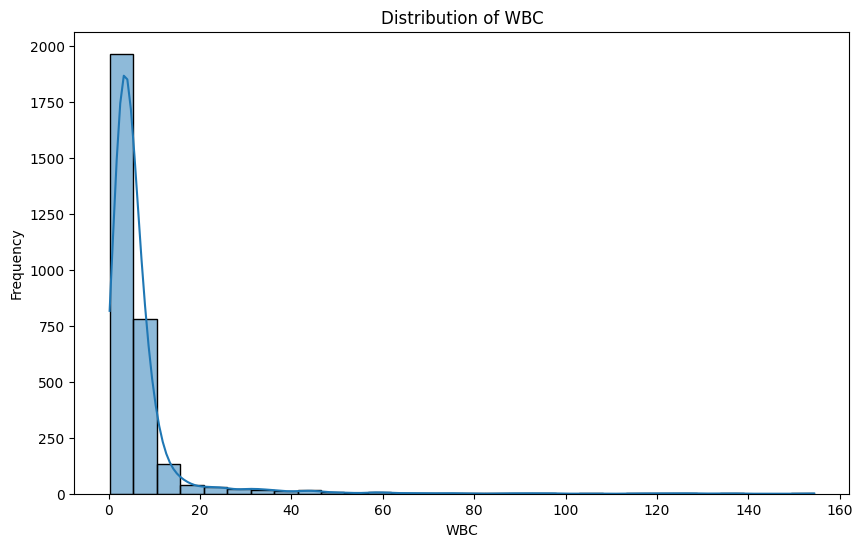

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

df['WBC_log'] = np.log(df['WBC'] + 1)

# Plot the distribution of WBC
plt.figure(figsize=(10, 6))
sns.histplot(df['WBC'].dropna(), kde=True, bins=30)
plt.title('Distribution of WBC')
plt.xlabel('WBC')
plt.ylabel('Frequency')
plt.show()

In [2]:
import pandas as pd
import re

def parse_cytogenetics(cyto_str):
    """
    Prend en entrée une chaîne décrivant la cytogénétique (ex : "46,xy,del(3)(q26q27)[15]/46,xy[5]")
    et retourne un dictionnaire de features utiles.
    """
    
    if pd.isna(cyto_str):
        # Si la valeur est manquante, on peut retourner un dictionnaire vide
        return {
            'num_subclones': 0, 'sex': None, 'avg_chromosomes': None,
            'total_mitoses': 0, 'num_translocations': 0, 'num_deletions': 0,
            'num_inversions': 0, 'num_duplications': 0, 'num_additions': 0,
            'num_monosomies': 0, 'num_trisomies': 0, 'complexity_score': 0
        }

    # Séparer la description en sous-clones (split sur '/')
    subclones = cyto_str.split('/')
    
    # On initialise des compteurs globaux
    total_mitoses = 0
    total_translocations = 0
    total_deletions = 0
    total_inversions = 0
    total_duplications = 0
    total_additions = 0
    total_monosomies = 0
    total_trisomies = 0
    
    # Liste pour stocker le nombre de chromosomes détectés dans chaque sous-clone
    clone_chromosome_numbers = []
    
    # Pour détecter le sexe
    sex = None
    
    for clone in subclones:
        # Exemple de clone : "46,xy,del(3)(q26q27)[15]" ou "46,xx[10]"
        
        # Extraire le nombre de mitoses dans [x], s'il existe
        mitoses = 0
        mitoses_match = re.search(r'\[(\d+)\]', clone)
        if mitoses_match:
            mitoses = int(mitoses_match.group(1))
        total_mitoses += mitoses
        
        # Retirer la partie [x]
        clone_clean = re.sub(r'\[\d+\]', '', clone)
        
        # Split par virgule
        parts = clone_clean.split(',')
        
        for p in parts:
            p = p.strip().lower()
            
            # Nombre de chromosomes ?
            if re.match(r'^\d+$', p):
                # ex : "46"
                clone_chromosome_numbers.append(int(p))
            
            # Détecter le sexe
            if "xy" in p:
                if sex is None:
                    sex = "XY"
                elif sex != "XY":
                    sex = "Mixed"
            elif "xx" in p:
                if sex is None:
                    sex = "XX"
                elif sex != "XX":
                    sex = "Mixed"
            
            # Rechercher anomalies
            if re.search(r't\(\d+;\d+\)', p):
                total_translocations += 1
            if "del(" in p:
                total_deletions += 1
            if "inv(" in p:
                total_inversions += 1
            if "dup(" in p:
                total_duplications += 1
            if "add(" in p:
                total_additions += 1
            
            # Trisomies / monosomies notées +7, -5, etc.
            plus_match = re.search(r'\+(\d+)', p)
            minus_match = re.search(r'\-(\d+)', p)
            if plus_match:
                total_trisomies += 1
            if minus_match:
                total_monosomies += 1
    
    # Nombre de sous-clones
    num_subclones = len(subclones)
    
    # Moyenne (non pondérée) du nombre de chromosomes
    if len(clone_chromosome_numbers) > 0:
        avg_chromosomes = sum(clone_chromosome_numbers) / len(clone_chromosome_numbers)
    else:
        avg_chromosomes = None
    
    complexity_score = (total_translocations + total_deletions + total_inversions +
                        total_duplications + total_additions)

    return {
        'num_subclones': num_subclones,
        'sex': sex if sex else "Unknown",
        'avg_chromosomes': avg_chromosomes,
        'total_mitoses': total_mitoses,
        'num_translocations': total_translocations,
        'num_deletions': total_deletions,
        'num_inversions': total_inversions,
        'num_duplications': total_duplications,
        'num_additions': total_additions,
        'num_monosomies': total_monosomies,
        'num_trisomies': total_trisomies,
        'complexity_score': complexity_score
    }


def parse_cytogenetics_column(df, column_name='CYTOGENETICS'):
    """
    Prend un DataFrame `df` et le nom de la colonne cytogénétique `column_name`.
    Retourne un nouveau DataFrame comprenant les features extraites.
    """
    # Appliquer la fonction parse_cytogenetics à chaque ligne
    parsed_series = df[column_name].apply(parse_cytogenetics)
    
    # Convertir la série de dictionnaires en DataFrame
    parsed_df = pd.json_normalize(parsed_series)
    
    # Concaténer avec le DataFrame d'origine (sans dupliquer la colonne de base si vous voulez la garder)
    # Si vous préférez garder la colonne CYTOGENETICS, ne la supprimez pas.
    final_df = pd.concat([df.drop(columns=[column_name]), parsed_df], axis=1)
    
    return final_df


# ---------------------------
# Exemple d'utilisation
# ---------------------------

# Parser la colonne "CYTOGENETICS"
df_parsed = parse_cytogenetics_column(df, column_name='CYTOGENETICS')

print(df_parsed)

           ID CENTER  BM_BLAST     WBC   ANC  MONOCYTES    HB    PLT  \
0     P132697    MSK      14.0    2.80  0.20       0.70   7.6  119.0   
1     P132698    MSK       1.0    7.40  2.40       0.10  11.6   42.0   
2     P116889    MSK      15.0    3.70  2.10       0.10  14.2   81.0   
3     P132699    MSK       1.0    3.90  1.90       0.10   8.9   77.0   
4     P132700    MSK       6.0  128.00  9.70       0.90  11.1  195.0   
...       ...    ...       ...     ...   ...        ...   ...    ...   
3318  P121828     VU       1.0    3.70  2.53       0.53   8.9  499.0   
3319  P121829     VU       0.0    4.20  2.40       0.22  10.6   49.0   
3320  P121830     VU       0.0    1.80  0.55       0.29   9.4   86.0   
3321  P121853     VU       5.0    1.37  0.37       0.11  11.4  102.0   
3322  P121834     VU       0.0    2.70  0.72       0.23   8.2  239.0   

      num_subclones sex  avg_chromosomes  total_mitoses  num_translocations  \
0                 2  XY        46.000000             20 

In [3]:
import numpy as np

# dans SEX_AVAILABLE mettre 1 si '46,xy' ou '46,xx' est présent dans la colonne 'CYTOGENETICS'
df['SEX_AVAILABLE'] = np.where(df['CYTOGENETICS'].str.contains('46,xy'), 1, 
                     np.where(df['CYTOGENETICS'].str.contains('46,xx'), 1, 0))

df['SEX'] = np.where(df['CYTOGENETICS'].str.contains('46,xy'), 1, 0)



In [4]:
df

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,SEX_AVAILABLE,SEX
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1,1
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,"46,xx",1,0
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1,1
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1,1
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",1,0
...,...,...,...,...,...,...,...,...,...,...,...
3318,P121828,VU,1.0,3.70,2.53,0.53,8.9,499.0,"46,xy[20]",1,1
3319,P121829,VU,0.0,4.20,2.40,0.22,10.6,49.0,"46,xy,del(13)(q12q14)[1]/45,x,-y,del(13)(q12q1...",1,1
3320,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,"46,xy,del(20)(q11.2q13.1)[4]/45,xy,idem,-7[16]",1,1
3321,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,"46,xx,del(1)(p34)[5]/45,xx,sl,-18[12]/46,xx,sd...",1,0


In [72]:
maf_df['EFFECT'].value_counts()

EFFECT
non_synonymous_codon            5471
frameshift_variant              2877
stop_gained                     1673
splice_site_variant              512
inframe_codon_loss               168
PTD                               89
inframe_codon_gain                55
ITD                               26
initiator_codon_change            24
2KB_upstream_variant              12
complex_change_in_transcript      11
3_prime_UTR_variant                5
stop_lost                          4
inframe_variant                    4
synonymous_codon                   3
stop_retained_variant              1
Name: count, dtype: int64

In [84]:
df.iloc[:,2:8].corr()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
BM_BLAST,1.000000,0.100346,-0.008412,0.140248,-0.054530,-0.218223
WBC,0.100346,1.000000,0.847096,0.748100,0.013184,0.020631
ANC,-0.008412,0.847096,1.000000,0.592817,0.012768,0.074716
MONOCYTES,0.140248,0.748100,0.592817,1.000000,0.041912,-0.019550
HB,-0.054530,0.013184,0.012768,0.041912,1.000000,-0.059378
PLT,-0.218223,0.020631,0.074716,-0.019550,-0.059378,1.000000


In [3]:
def process_y(target_df):
    # Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
    target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

    # Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
    target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

    # Ensure 'OS_STATUS' is boolean
    target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

    return Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

import featuretools as ft

def create_entity(status):

    clinical = pd.read_csv(f"data/X_{status}/clinical_{status}.csv")
    molecular = pd.read_csv(f"data/X_{status}/molecular_{status}.csv").reset_index()
    
    es = ft.EntitySet(id=status)

    es = es.add_dataframe(
        dataframe_name='clinical',
        dataframe=clinical,
        index='ID' 
    )

    es = es.add_dataframe(
        dataframe_name='molecular',
        dataframe=molecular,
        index='index'   
    )

    es.add_relationship(
        parent_dataframe_name='clinical',
        parent_column_name='ID',
        child_dataframe_name='molecular',
        child_column_name='ID'
    )

    return es

In [4]:
train = create_entity('train')
X, features_defs = ft.dfs(entityset=train, target_dataframe_name="clinical")

target = load_target()

# Create the survival data format
X = X.loc[X.index.isin(target['ID'])]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target)

# Sélectionner les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['category']).columns

# Retirer les colonnes catégorielles
X = X.drop(categorical_columns, axis=1)




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python

NameError: name 'load_target' is not defined

In [33]:
train.graph_feature(features_defs[1])

AttributeError: 'EntitySet' object has no attribute 'graph_feature'

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.73
LightGBM Survival Model Concordance Index IPCW on test: 0.69


In [7]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [8]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.24041e-29): result may not be accurate.
  delta = solve(
/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.78327e-29): result may not be accurate.
  delta = solve(
/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.76974e-29): result may not be accurate.
  delta = solve(
/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.02554e-29): result may not be accurate.
  delta = solve(
/Users/julesmour

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.70
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.67


/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.77163e-29): result may not be accurate.
  delta = solve(
/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.86392e-29): result may not be accurate.
  delta = solve(
/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_6769/1910974199.py:3: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  cox.fit(X_train, y_train)


# Predict

In [5]:
test = create_entity('test')
X_eval, features_defs = ft.dfs(entityset=test, target_dataframe_name="clinical")

# Sélectionner les colonnes catégorielles
categorical_columns = X_eval.select_dtypes(include=['category']).columns

# Retirer les colonnes catégorielles
X_eval = X_eval.drop(categorical_columns, axis=1)

# Survival-aware imputation for missing values
X_eval = imputer.transform(X_eval)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python

NameError: name 'imputer' is not defined

In [28]:
X_eval

array([[6.80000000e+01, 3.45000000e+00, 5.86500000e-01, ...,
        3.50606669e+08, 3.50606669e+08, 9.84900000e-01],
       [3.50000000e+01, 3.18000000e+00, 1.24020000e+00, ...,
        2.68078789e+08, 2.68078789e+08, 8.43000000e-01],
       [3.30000000e+00, 1.24000000e+01, 8.68000000e+00, ...,
        1.68203756e+08, 1.68203755e+08, 4.88000000e-01],
       ...,
       [3.30000000e+00, 4.03000000e+00, 2.00000000e+00, ...,
        7.57755900e+06, 7.57755900e+06, 1.22000000e-01],
       [3.30000000e+00, 4.03000000e+00, 2.00000000e+00, ...,
        5.02407207e+08, 5.02407207e+08, 9.17000000e-01],
       [3.30000000e+00, 4.03000000e+00, 2.00000000e+00, ...,
        1.19940632e+08, 1.19940632e+08, 1.13300000e+00]], shape=(1193, 36))

In [1]:
from src.utilities import create_entity, predict_and_save, split_data
from src.preprocess import process_missing_values, main_preprocess
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw

data = create_entity()

data = main_preprocess(data)

X, X_eval, y = split_data(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python

In [2]:
X.columns

Index(['alt_A', 'alt_G', 'alt_C', 'alt_T', 'ref_A', 'ref_G', 'ref_C', 'ref_T',
       'effect_2KB_upstream_variant', 'effect_3_prime_UTR_variant',
       ...
       'SKEW(molecular.START)', 'SKEW(molecular.VAF)', 'STD(molecular.DEPTH)',
       'STD(molecular.END)', 'STD(molecular.START)', 'STD(molecular.VAF)',
       'SUM(molecular.DEPTH)', 'SUM(molecular.END)', 'SUM(molecular.START)',
       'SUM(molecular.VAF)'],
      dtype='object', length=113)

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,num_subclones,sex,avg_chromosomes,total_mitoses,...,SKEW(molecular.START),SKEW(molecular.VAF),STD(molecular.DEPTH),STD(molecular.END),STD(molecular.START),STD(molecular.VAF),SUM(molecular.DEPTH),SUM(molecular.END),SUM(molecular.START),SUM(molecular.VAF)
ID,,,,,,,,,,,,,,,,,,,,,
P132697,14.0,2.80,0.20,0.70,7.6,119.0,2,1,46.00,20,...,2.716919,-0.351409,764.974473,2.513850e+07,2.513850e+07,0.147784,15374.0,368240810.0,368240806.0,2.2642
P132698,1.0,7.40,2.40,0.10,11.6,42.0,1,-1,46.00,0,...,-1.563079,1.337111,838.071795,1.740565e+07,1.740565e+07,0.008568,4204.0,70975297.0,70975295.0,0.8186
P116889,15.0,3.70,2.10,0.10,14.2,81.0,2,1,46.00,20,...,-1.090151,1.732051,266.447618,8.510852e+07,8.510852e+07,0.007506,5309.0,379187807.0,379187807.0,0.1180
P132699,1.0,3.90,1.90,0.10,8.9,77.0,2,1,46.00,20,...,1.012376,0.600125,431.626101,5.305907e+07,5.305907e+07,0.136217,12605.0,745312555.0,745312531.0,2.3015
P132700,6.0,128.00,9.70,0.90,11.1,195.0,2,-1,46.00,20,...,NaN,NaN,NaN,NaN,NaN,NaN,713.0,31022442.0,31022441.0,0.4721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P121826,1.0,2.50,1.02,0.20,10.2,78.0,2,1,46.00,10,...,1.773439,1.993807,153.384050,3.639440e+07,3.639440e+07,0.221448,4588.0,210398850.0,210398850.0,0.6760
P121827,1.5,8.10,2.66,0.45,11.3,40.0,1,-1,44.00,20,...,NaN,NaN,300.520382,1.379568e+07,1.379568e+07,0.553665,1869.0,34665109.0,34665109.0,0.8550
P121830,0.0,1.80,0.55,0.29,9.4,86.0,2,1,45.50,20,...,0.007114,-0.198722,388.933628,5.872922e+07,5.872922e+07,0.163770,4613.0,487445256.0,487445255.0,1.4679


In [8]:

##############################################
# Fit a CoxPH model
##############################################

# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

# Predict and save the results
#predict_and_save(X_eval, cox, method="featuretools_del_impute_median_cyto_processed")

Ill-conditioned matrix (rcond=5.53742e-34): result may not be accurate.
Ill-conditioned matrix (rcond=3.51253e-33): result may not be accurate.
Ill-conditioned matrix (rcond=7.58181e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.36296e-34): result may not be accurate.
Ill-conditioned matrix (rcond=3.15446e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.87871e-34): result may not be accurate.
Ill-conditioned matrix (rcond=5.41352e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.41127e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.56554e-33): result may not be accurate.
Ill-conditioned matrix (rcond=2.89171e-35): result may not be accurate.
Ill-conditioned matrix (rcond=1.81739e-33): result may not be accurate.
Ill-conditioned matrix (rcond=1.01912e-33): result may not be accurate.
Ill-conditioned matrix (rcond=2.23658e-34): result may not be accurate.
Ill-conditioned matrix (rcond=2.03799e-33): result may not be ac

ValueError: search direction contains NaN or infinite values

In [4]:

##############################################
# Fit a CoxPH model
##############################################

# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

# Predict and save the results
#predict_and_save(X_eval, cox, method="featuretools_del_impute_median_cyto_processed")

Ill-conditioned matrix (rcond=5.53742e-34): result may not be accurate.
Ill-conditioned matrix (rcond=2.55897e-33): result may not be accurate.
Ill-conditioned matrix (rcond=3.15394e-33): result may not be accurate.
Ill-conditioned matrix (rcond=6.84822e-34): result may not be accurate.
Ill-conditioned matrix (rcond=3.05498e-33): result may not be accurate.
Ill-conditioned matrix (rcond=1.75714e-33): result may not be accurate.
Ill-conditioned matrix (rcond=2.95173e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.40813e-33): result may not be accurate.
Ill-conditioned matrix (rcond=8.39759e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.63791e-34): result may not be accurate.
Ill-conditioned matrix (rcond=2.91474e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.54514e-34): result may not be accurate.
Ill-conditioned matrix (rcond=1.6822e-33): result may not be accurate.
Ill-conditioned matrix (rcond=1.0962e-33): result may not be accu

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.73
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68


Ill-conditioned matrix (rcond=6.48041e-34): result may not be accurate.
Optimization did not converge: Maximum number of iterations has been exceeded.
X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names


In [2]:
import lightgbm as lgb

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'verbose': 1
}

X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

# Predict and save the results
predict_and_save(X_eval, model, method="featuretools_del_impute_median_cyto_processed_depth5_lr005")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8076
[LightGBM] [Info] Number of data points in the train set: 2221, number of used features: 103
[LightGBM] [Info] Start training from score 2.464379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Survival Model Concordance Index IPCW on train: 0.73
LightGBM Survival Model Concordance Index IPCW on test: 0.69


In [6]:
import shap
import lightgbm as lgb
import pandas as pd
import numpy as np

# 1. Votre entraînement LightGBM (déjà fait)
lgbm_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'verbose': 1
}
train_dataset = lgb.Dataset(X_train, label=y_train['OS_YEARS'])
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Assurez-vous que X_train est un DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)

# 2. Créer l'explainer SHAP
explainer = shap.Explainer(model)

# 3. Calculer les valeurs SHAP sur l’échantillon d’entraînement
#    (sur tout X_train ou un subset si X_train est trop grand)
shap_values = explainer.shap_values(X_train)

# 4. Visualiser l’explication globale via un summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")
# Le paramètre plot_type="bar" permet d’avoir un diagramme de barres
# (importance moyenne absolue). Sans ce paramètre, vous aurez un summary_plot
# en forme de nuage de points.

# 5. Si vous voulez un nuage de points coloré par la valeur de la feature
# (pour voir les interactions), retirez plot_type="bar":
shap.summary_plot(shap_values, X_train)

# 6. Visualiser l’explication locale (pour un seul patient, par exemple)


# Sélectionnons le premier patient
patient_idx = 1
shap.force_plot(
    explainer.expected_value,
    shap_values[patient_idx, :],
    X_train.iloc[patient_idx, :],
    matplotlib=True
)

NameError: name 'X_train' is not defined

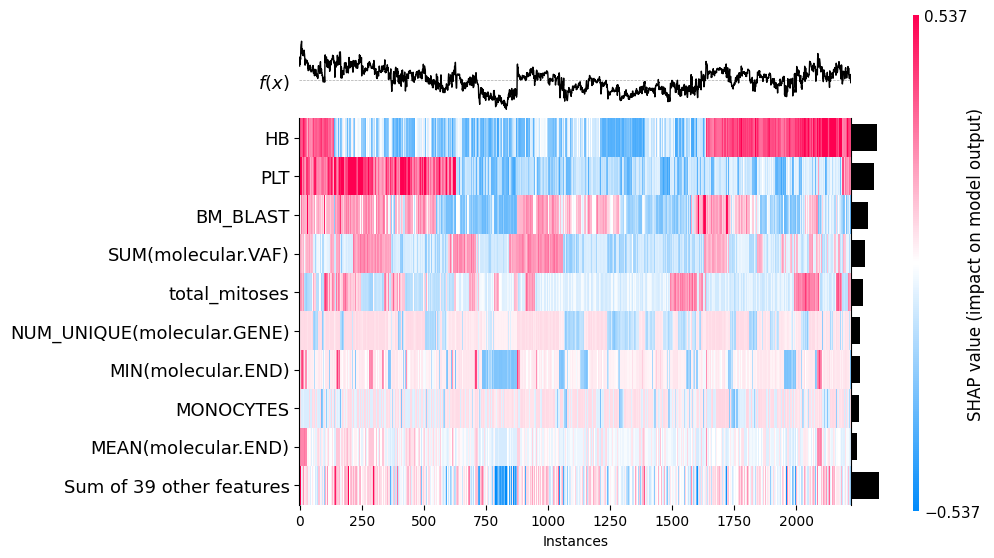

In [37]:
shap.plots.heatmap(explainer(X_train))

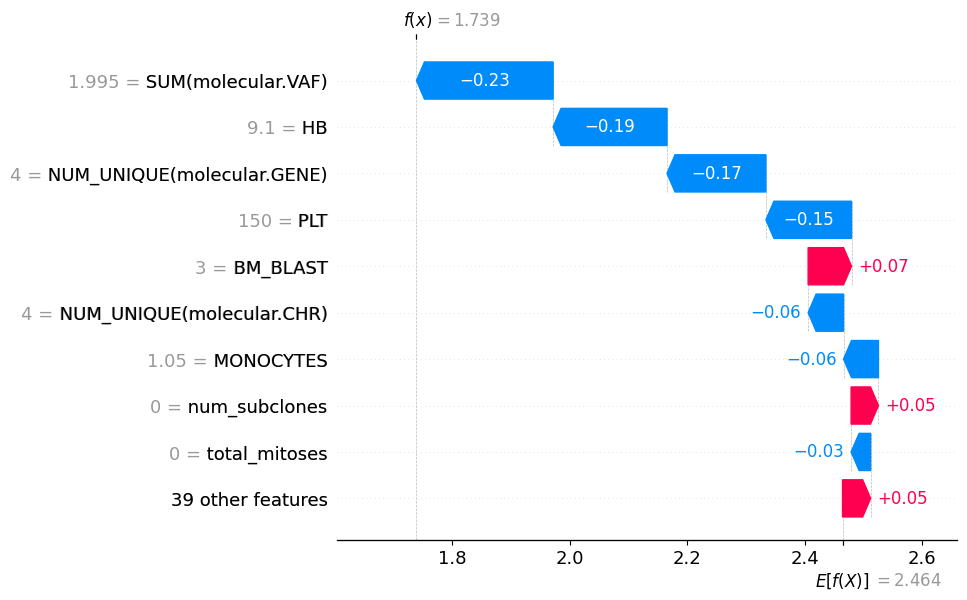

In [39]:
shap.plots.waterfall(explainer(X_train)[0])

In [27]:
shap_values

array([[ 0.07390235,  0.01828787, -0.03102366, ...,  0.        ,
         0.        , -0.23263576],
       [-0.19877647,  0.018812  ,  0.01604023, ...,  0.        ,
         0.        , -0.13191289],
       [-0.26174907,  0.0171288 ,  0.01604023, ...,  0.        ,
         0.        , -0.09951053],
       ...,
       [ 0.52000685,  0.018812  ,  0.0206288 , ...,  0.        ,
         0.        , -0.05887342],
       [ 0.20248105, -0.01344595,  0.01408238, ...,  0.        ,
         0.        , -0.05336326],
       [ 0.23298206, -0.01344595,  0.01617094, ...,  0.        ,
         0.        , -0.05336326]])

In [24]:
shap.initjs()

shap.plots.force(
    base_value=explainer.expected_value, 
    shap_values=shap_values[:500],
    features=X_train.iloc[:500],  
)

In [6]:
train_dataset

In [45]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("data/X_train/clinical_train.csv")
df_eval = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("data/X_test/molecular_test.csv")

target_df = pd.read_csv("data/target_train.csv")
target_df_test = pd.read_csv("data/random_submission_FRacdcw_v9kP4pP.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [46]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

ValueError: event indicator must be binary

In [43]:
X

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,num_subclones,sex,avg_chromosomes,total_mitoses,...,SKEW(molecular.START),SKEW(molecular.VAF),STD(molecular.DEPTH),STD(molecular.END),STD(molecular.START),STD(molecular.VAF),SUM(molecular.DEPTH),SUM(molecular.END),SUM(molecular.START),SUM(molecular.VAF)
ID,,,,,,,,,,,,,,,,,,,,,
P132697,14.0,2.80,0.20,0.70,7.6,119.0,2,1,46.00,20,...,2.716919,-0.351409,764.974473,2.513850e+07,2.513850e+07,0.147784,15374.0,368240810.0,368240806.0,2.2642
P132698,1.0,7.40,2.40,0.10,11.6,42.0,1,-1,46.00,0,...,-1.563079,1.337111,838.071795,1.740565e+07,1.740565e+07,0.008568,4204.0,70975297.0,70975295.0,0.8186
P116889,15.0,3.70,2.10,0.10,14.2,81.0,2,1,46.00,20,...,-1.090151,1.732051,266.447618,8.510852e+07,8.510852e+07,0.007506,5309.0,379187807.0,379187807.0,0.1180
P132699,1.0,3.90,1.90,0.10,8.9,77.0,2,1,46.00,20,...,1.012376,0.600125,431.626101,5.305907e+07,5.305907e+07,0.136217,12605.0,745312555.0,745312531.0,2.3015
P132700,6.0,128.00,9.70,0.90,11.1,195.0,2,-1,46.00,20,...,NaN,NaN,NaN,NaN,NaN,NaN,713.0,31022442.0,31022441.0,0.4721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P121826,1.0,2.50,1.02,0.20,10.2,78.0,2,1,46.00,10,...,1.773439,1.993807,153.384050,3.639440e+07,3.639440e+07,0.221448,4588.0,210398850.0,210398850.0,0.6760
P121827,1.5,8.10,2.66,0.45,11.3,40.0,1,-1,44.00,20,...,NaN,NaN,300.520382,1.379568e+07,1.379568e+07,0.553665,1869.0,34665109.0,34665109.0,0.8550
P121830,0.0,1.80,0.55,0.29,9.4,86.0,2,1,45.50,20,...,0.007114,-0.198722,388.933628,5.872922e+07,5.872922e+07,0.163770,4613.0,487445256.0,487445255.0,1.4679
